In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt
import numpy as np


In [81]:
data = pd.read_csv('Data/RFLFSODataFull.csv')

In [82]:
data.head()

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83500000000,0.0,0.0,0.0,...,26.603030,24.680849,9,65884.51846,72336.362233,65617.543754,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73500000000,0.0,0.0,0.0,...,26.377164,24.313108,9,64963.41092,68753.386153,60379.327485,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83500000000,0.0,0.0,0.0,...,27.670822,23.150277,10,54794.28107,54821.773817,50850.155963,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73500000000,0.0,0.0,0.0,...,26.522100,23.174815,10,50205.64159,52519.927530,45374.510898,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83500000000,0.0,0.0,0.0,...,26.305736,24.864100,10,59038.32599,64418.329138,54461.246506,84.167414,1.881007,4.476298,1.874052


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  int64  
 15  Te

### Exploratary Data Analysis

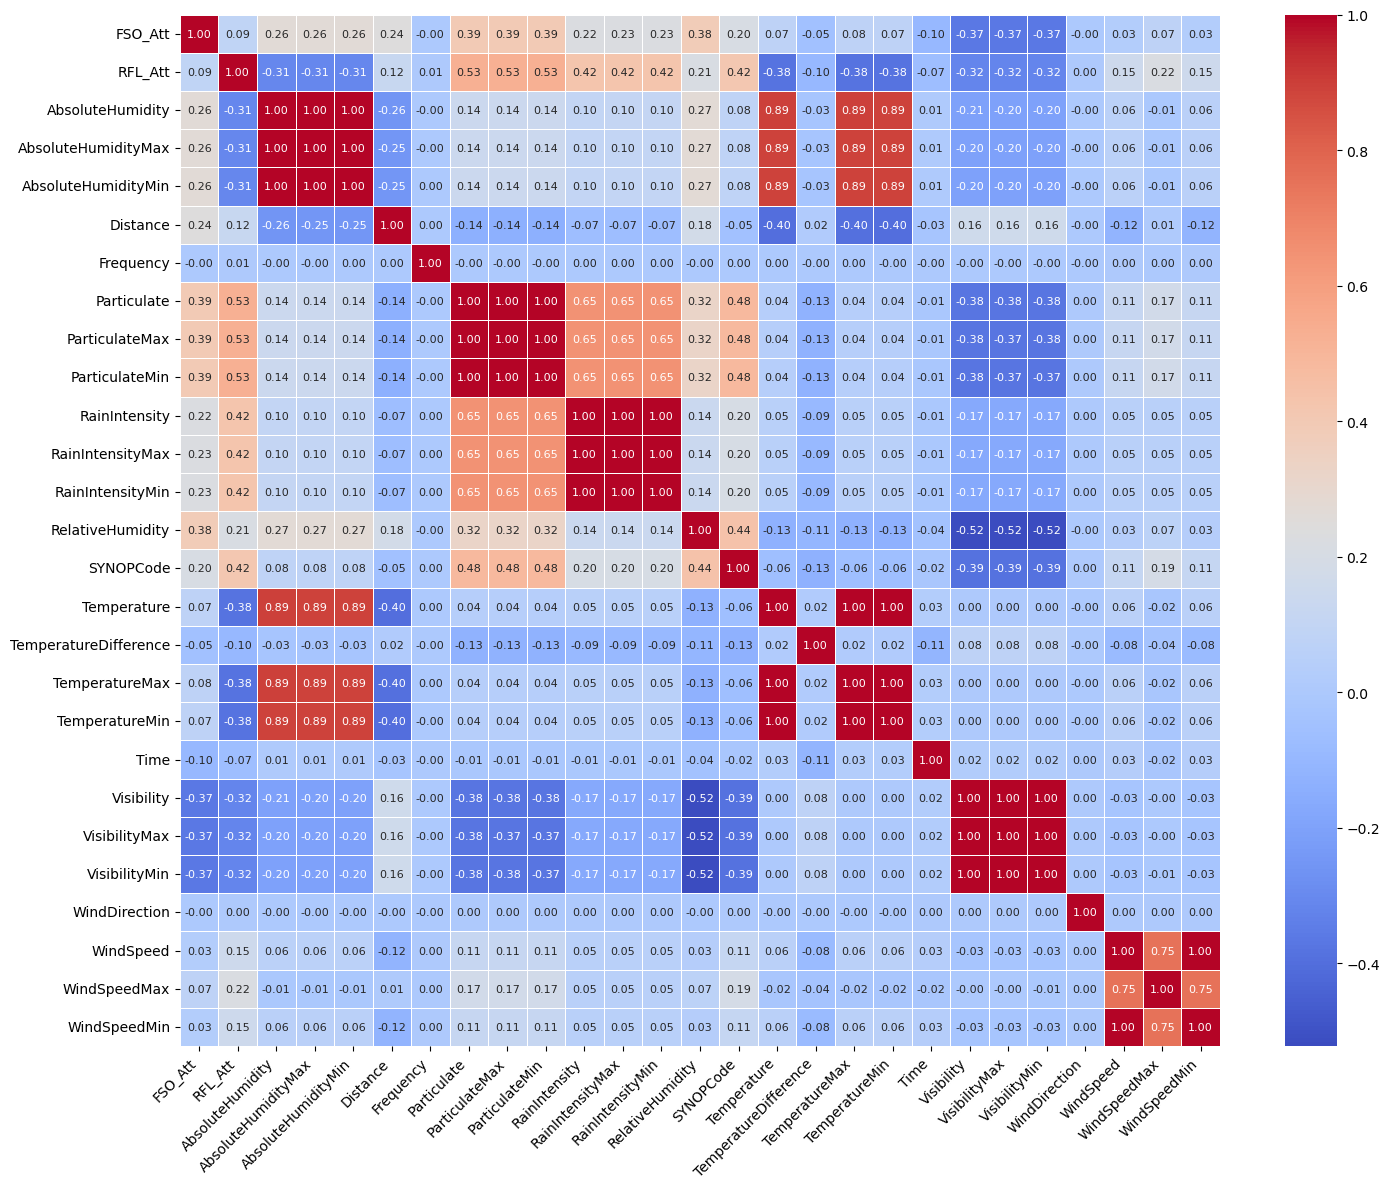

In [84]:
# Heatmap to visualize the correlation between features
plt.figure(figsize=(15, 12))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8}, linewidths=0.5)
# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

There is high correlation among the groups of humidity, particulate, rain, temperature, visibility and wind speed features, these can lead to collearity among features reducing the accuracy of the prediction model. For FSO_Att the Humidity, rain and particulate features show a positive correlation while visibilty shows a negative correlation. Temperature and and windspeed seems ot have no effect on FSO_Att. 

Similarly for RFL_Att, Rain and particulate feature show a positive correlation while visibilty shows a negative correlation. However, humidity features have a negative correlation with attenuation. Notably, the SYNOP Code shows a higher correlation with RFL_Att than FSO_Att indicating than RFL_Att is affected by diffferent weather conditions. RFL_att is also affected by varying wind conditions and Temperatures which seemed to have no effect on FSO_Att.

 ### Target Variable Distribution

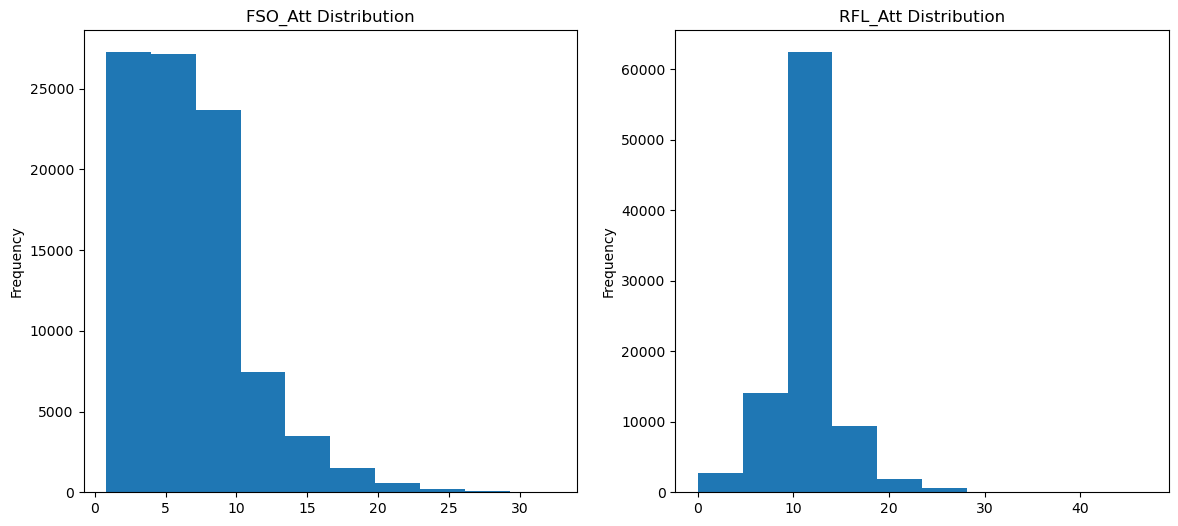

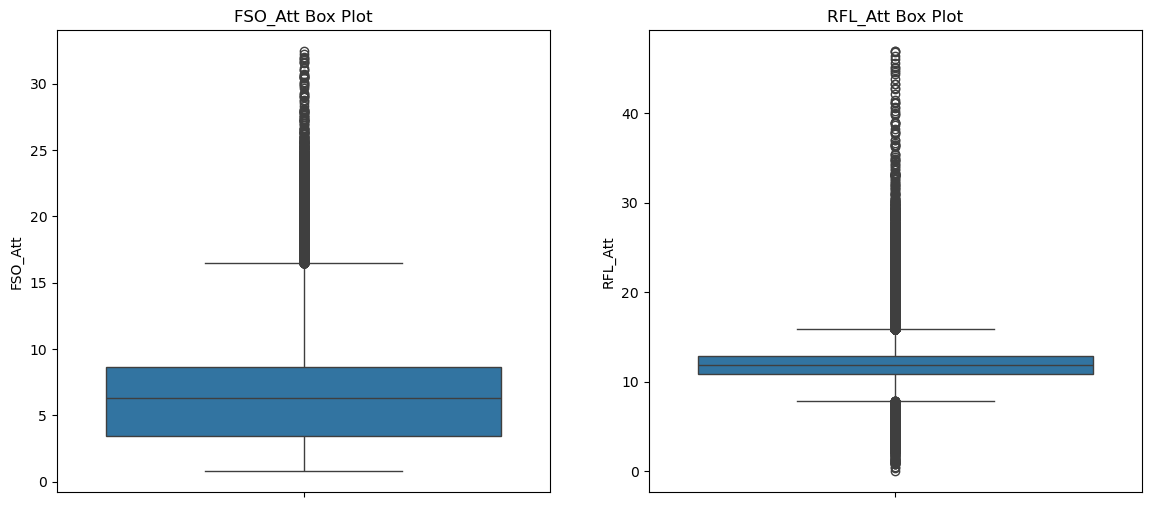

In [85]:
# Histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
data['FSO_Att'].plot(kind='hist', ax=axes[0], title='FSO_Att Distribution')
data['RFL_Att'].plot(kind='hist', ax=axes[1], title='RFL_Att Distribution')
plt.show()

# Box Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(data['FSO_Att'], ax=axes[0]).set_title('FSO_Att Box Plot')
sns.boxplot(data['RFL_Att'], ax=axes[1]).set_title('RFL_Att Box Plot')
plt.show()


#### Continous Variable Analysis

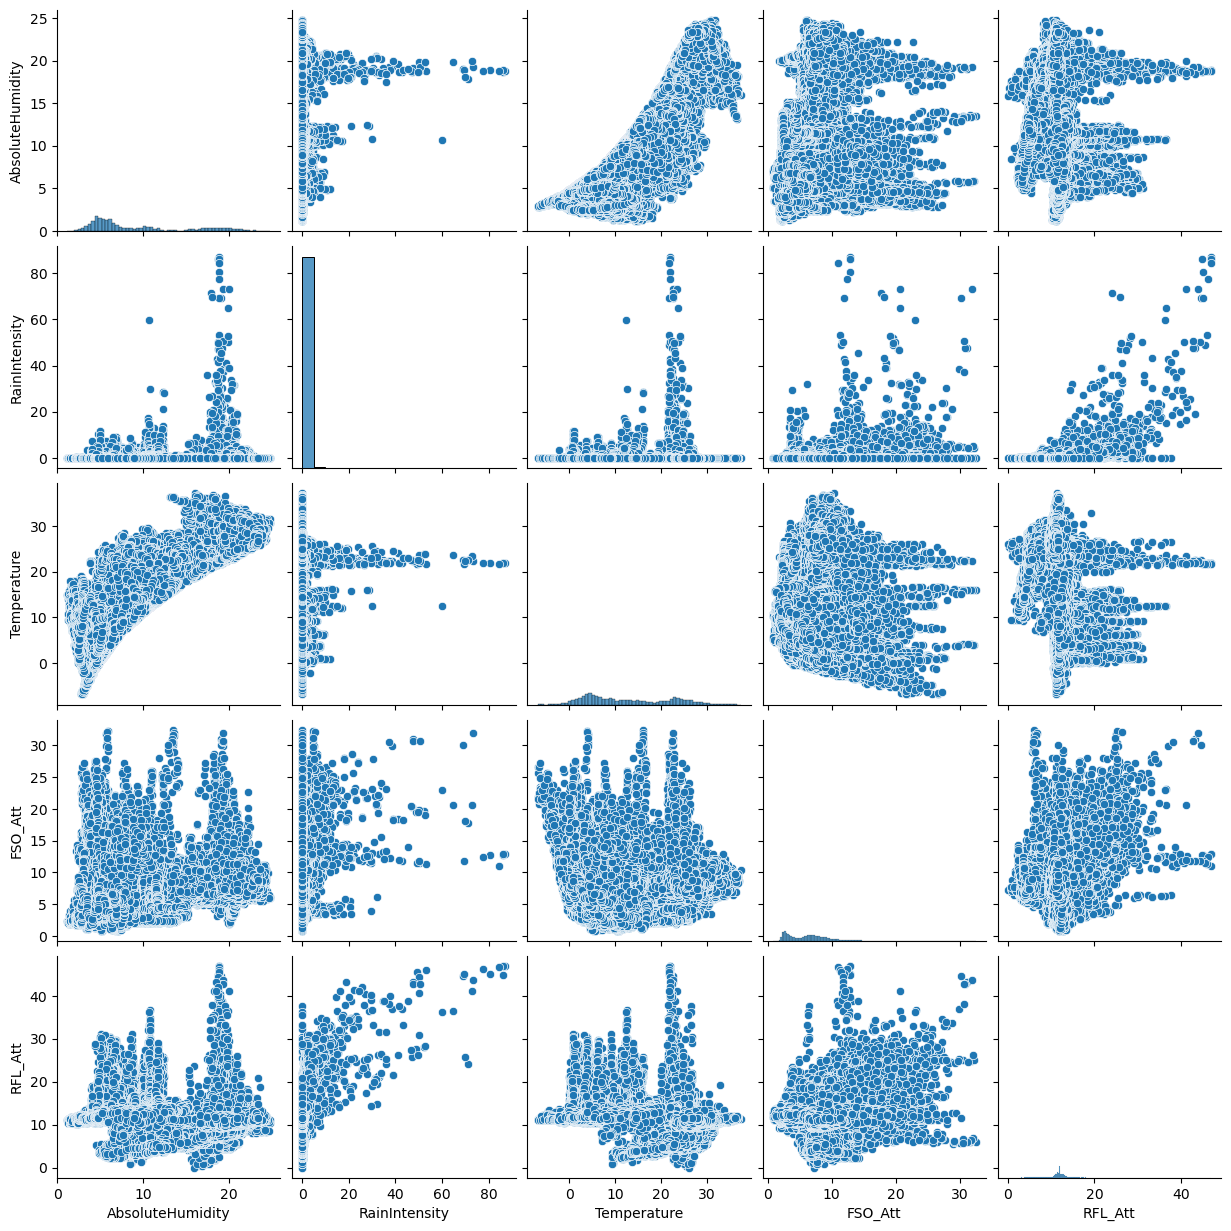

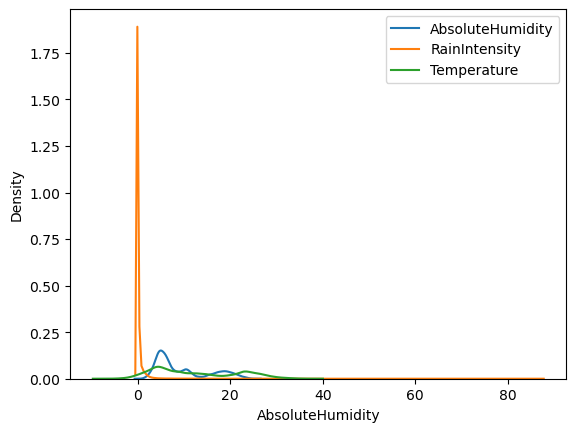

In [86]:
# Pair Plot
sns.pairplot(data[['AbsoluteHumidity', 'RainIntensity', 'Temperature', 'FSO_Att', 'RFL_Att']])
plt.show()

# KDE Plots for selected features
for feature in ['AbsoluteHumidity', 'RainIntensity', 'Temperature']:
    sns.kdeplot(data[feature], label=feature)
plt.legend()
plt.show()


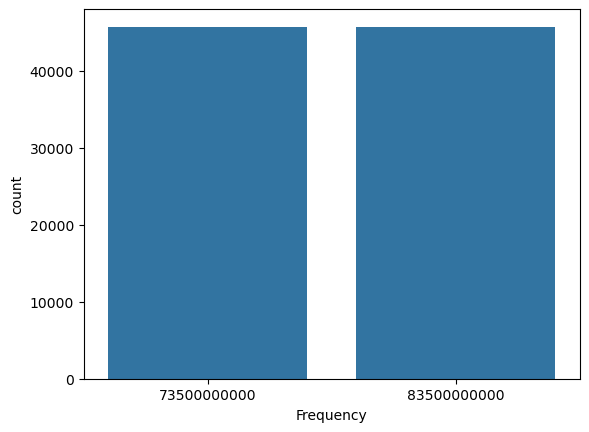

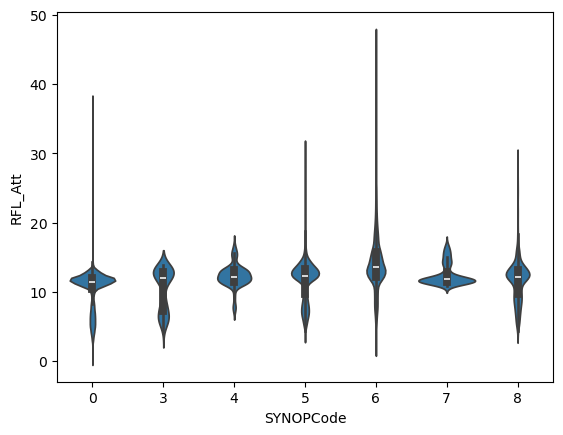

In [87]:
# Count Plot
sns.countplot(x='Frequency', data=data)
plt.show()

# Violin Plot of `RFL_Att` by `SYNOPCode`
sns.violinplot(x='SYNOPCode', y='RFL_Att', data=data)
plt.show()



In [88]:
## Feature Selection

In [90]:
# Identify point where R² decrease is less than 1% and RMSE increase is grater than 5%
def find_threshold(data_table):
    for i in range(0, len(data_table)):
        r2_decrease = (data_table['R2'].iloc[i] - data_table['R2'].iloc[i + 1])/ (data_table['R2'].iloc[i])
        rmse_increase = ( data_table['RMSE'].iloc[i + 1]- data_table['RMSE'].iloc[i])/ (data_table['RMSE'].iloc[i])
        # The relative decrease in R² between iterations is small ( below a threshold 0.01 or 1%).
        # The relative increase in RMSE between iterations exceeds a threshold (0.05 or 5%).
        if r2_decrease > 0.01 and  rmse_increase > 0.05 : 
            return i
    return len(data_table) - 1  # Default to the last index if no threshold found

fso_threshold = find_threshold(fso_table)
rfl_threshold = find_threshold(rfl_table)

In [ ]:
fso_threshold

15

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/2406998983.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=synop_counts.index, y=synop_counts.values, palette="viridis")


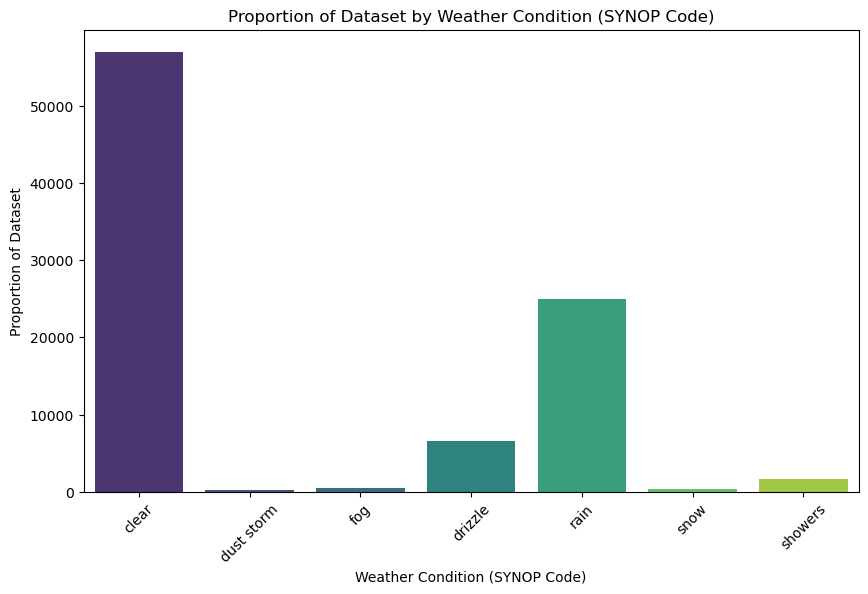

In [ ]:
# Define SYNOP code descriptions and filter the dataset by each code
synop_codes = {
    0: "clear",
    3: "dust storm",
    4: "fog",
    5: "drizzle",
    6: "rain",
    7: "snow",
    8: "showers"
}

# Plot the proportions of the dataset for each SYNOP code
synop_counts = data['SYNOPCode'].value_counts().reindex(synop_codes.keys(), fill_value=0)
synop_counts.index = synop_counts.index.map(synop_codes)
plt.figure(figsize=(10, 6))
sns.barplot(x=synop_counts.index, y=synop_counts.values, palette="viridis")
plt.xlabel("Weather Condition (SYNOP Code)")
plt.ylabel("Proportion of Dataset")
plt.title("Proportion of Dataset by Weather Condition (SYNOP Code)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
rfl_table.columns


Index(['Removed_Feature', 'RMSE', 'R2'], dtype='object')

### Method 1 (Specific Random Forest)

-2.5118251684773306e-05 -0.00023287051579434602
-0.00032680817945275647 -0.00303557042032994
0.00020537272825463105 0.001915126280572357
3.1339645702760045e-05 0.00029130643034612285
-3.760088404311726e-05 -0.0003494029565867065
-0.0016229148763097856 -0.015204864751471595
-2.8122725337289226e-06 -2.7005252564476596e-05
8.686896325353786e-05 0.0008338602233736648
2.7529268675076507e-05 0.00026386714845721114
-0.00110898899600653 -0.010682179841847253
0.00142211114517573 0.013840601549383531
0.006607429068332638 0.061042821539976665
-0.0010397826169644664 -0.00877336199243502
0.0019230090563735589 0.01632564145175734
0.001646334529150291 0.013524123425692635
0.008820277714382043 0.06854585828560472
-0.001879623288770767 -0.013202231517661893
0.04321345393062692 0.27296987270022754
0.00015118294149016757 0.003483890093142554
-0.00022622943516082653 -0.005198889022674523
0.0004663585936679128 0.0107460661415497
-0.0002734206178615517 -0.006216605885261837
-0.00017670879204987903 -0.004064

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rfl_table_final = pd.concat([rfl_table_final, rfl_table])
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fso_table_final = pd.concat([fso_table_final, fso_table])
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:65: UserWarning: set_ticklabels() should only b

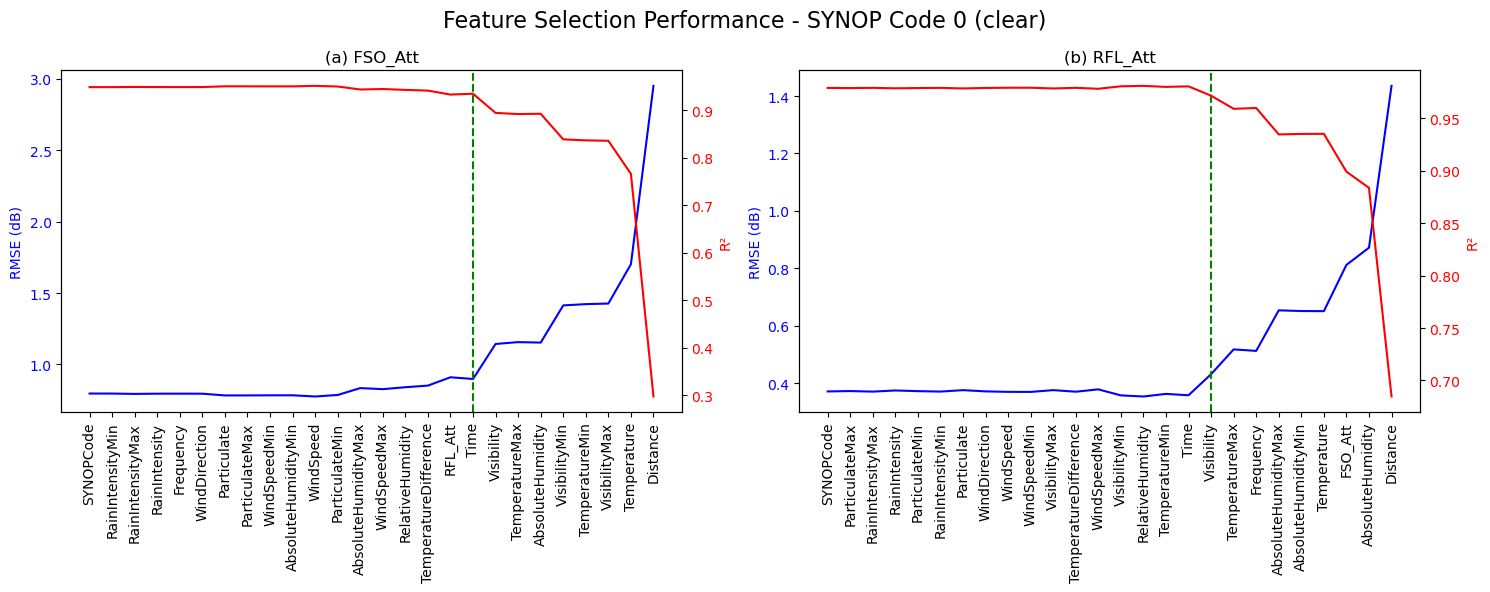

-0.0006990365144427829 -0.007113788852262712
0.0039008728421254532 0.039377870380627504
-0.0008020103129610471 -0.007641104534757344
0.00048434139802749606 0.004660849488610751
-0.0007131963698771824 -0.006835511598066345
-7.297430474828926e-05 -0.0007074013935119689
-0.002261357636330299 -0.02219237890594546
0.0015882260261401362 0.01602906986949333
-0.002719990689881105 -0.027130594430683233
0.003654900859081582 0.03739902818998013
-0.005325400877531796 -0.05278584944595866
0.0008302014659536232 0.00893730008970582
-0.0006327003728247265 -0.006738044611495706
0.002130728760444109 0.02268026833914875
-0.0011015836467931923 -0.011379066285262683
-0.004929953846596359 -0.0532843952558753
0.0015298032866843509 0.017885271497348663
0.006195521394043181 0.06810805807679089
0.010166695931967652 0.09605957114795481
9.257254953938272e-05 0.0014740994165022348
-0.001092013374611776 -0.01750209736538328
0.0005311031478754174 0.008712578092199295
-0.0025600426401440972 -0.042327954124490946
0.00

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(fso_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)


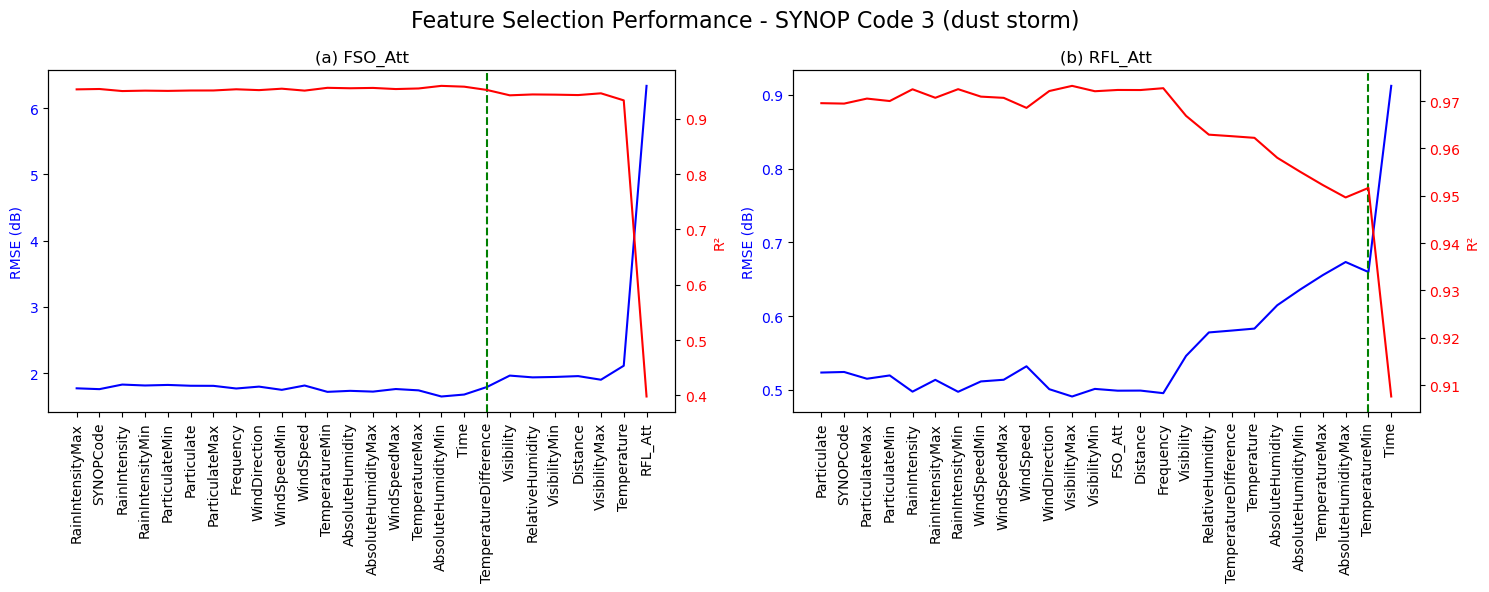

-0.001173116547117351 -0.0226739643399159
0.0004658067582365792 0.00928664222355309
-0.0002598809635644645 -0.00512060474628058
0.0007280439296240954 0.014356765334497184
-8.107676328048376e-05 -0.0015651070437440304
-0.00169341764797819 -0.033324584973844815
0.00044750076823261466 0.009239932823348354
0.0010625387374853313 0.021400113342195756
-0.0009802812943252419 -0.019293035812057265
0.0003265945508108687 0.006603352598359872
-8.126177210921491e-05 -0.0016276775126729435
-1.2225421924906216e-05 -0.0002455250931490426
0.002851235724942773 0.05573066321749945
-0.0012321334905864363 -0.022397510433114453
0.0006706223519605748 0.012549390807754664
-0.0014301147108078875 -0.026602576796120957
-0.001095800695832084 -0.021488227046436173
0.005685313024412854 0.10933518987964741
0.004285794231172543 0.06792747446695459
0.002427678394939924 0.03415140051367425
0.06087644982560663 0.6201536898206769
0.0009540795167723379 0.007123163315276516
0.00046955501478806603 0.003459302911238958
-0.00

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(fso_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)


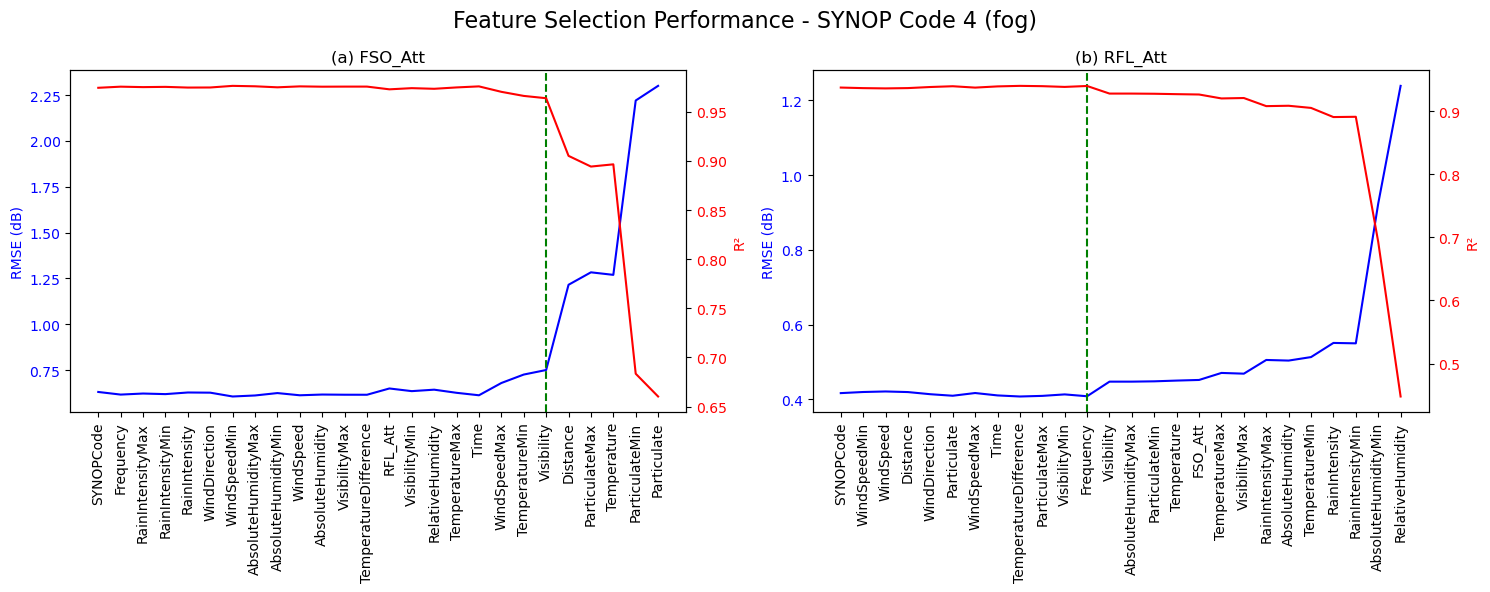

-0.00033870927127614995 -0.0028683447043228627
-0.0003183467859796738 -0.002712144522253562
0.00019014073734485896 0.0016257078270181422
-0.0011195130984279183 -0.009592767554974275
-0.0006019228919227557 -0.005252522712661151
-0.0007606525841571481 -0.006716886361477801
-0.0005378629312777903 -0.004813076728435377
-0.000848963162853125 -0.007685816058443514
-0.000722513819759464 -0.006644932999791005
0.0002835360041550315 0.002632332531739457
0.005219506020785487 0.04714206624160267
0.0006092210184759562 0.005096626560369124
0.003206185001712815 0.026257709928420327
0.00019423038940388657 0.0015240940786369285
-0.0012474487952851456 -0.009812439067704088
0.015307144859204393 0.11566501791244131
-9.795126391474597e-05 -0.0013000347711614906
-0.0003328562284970544 -0.0044366602024555925
-0.0003781013792991528 -0.0050881075300039155
1.9577590152201514e-05 0.000265545073695868
-0.0010076310165671846 -0.013756137504413122
3.00420625028424e-05 0.0004190878457965915
-0.00011775908020220465 -

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(fso_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)


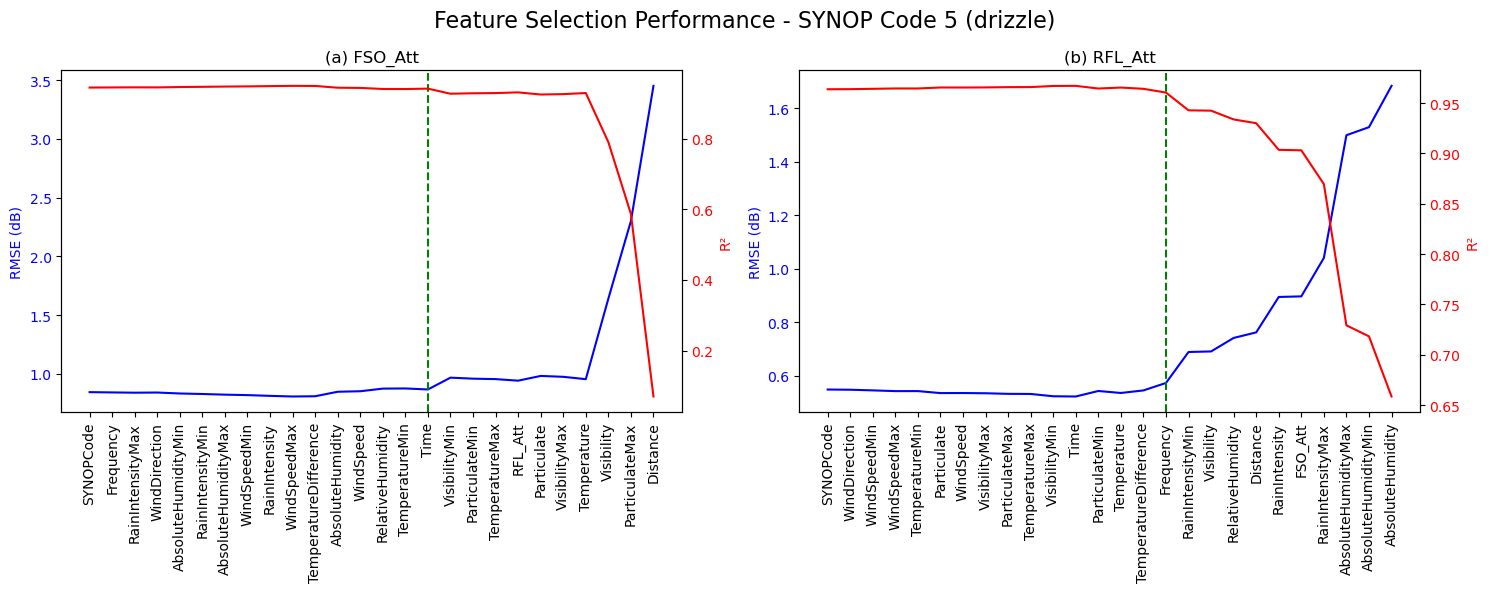

3.2293401994060914e-05 0.0004307490676847542
-0.0001888221593404554 -0.0025200927267346558
-0.0005896750708466982 -0.007932835628528298
2.6736671604858562e-05 0.00036415963740094834
1.521435691547869e-05 0.00020708293470001537
-0.0006657125865072868 -0.009099476760199697
-0.0002871057878590443 -0.003989212580222126
-9.511922709508359e-05 -0.0013308591913065947
-0.0009291530068132359 -0.013113448543201995
0.0008161183990600584 0.011691317494283078
-0.0009515411487966861 -0.013475804935970559
0.0017943906498534732 0.025631564373606645
-0.0008730529113396712 -0.012058485993299043
0.0014123421243093532 0.01968918413462283
0.006440297222736945 0.08358301234088879
-0.0007060599340095569 -0.008110897660347153
0.02383765369174431 0.24691612199277937
-0.00012052937996359204 -0.002176932380025487
-0.0006169957515287279 -0.011244888863966284
-0.00018108024422899786 -0.0033644724155787314
-0.00012707952739241202 -0.0023763615854572482
-5.601014843969393e-07 -1.0512628945214122e-05
-0.0003599456952

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(fso_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)


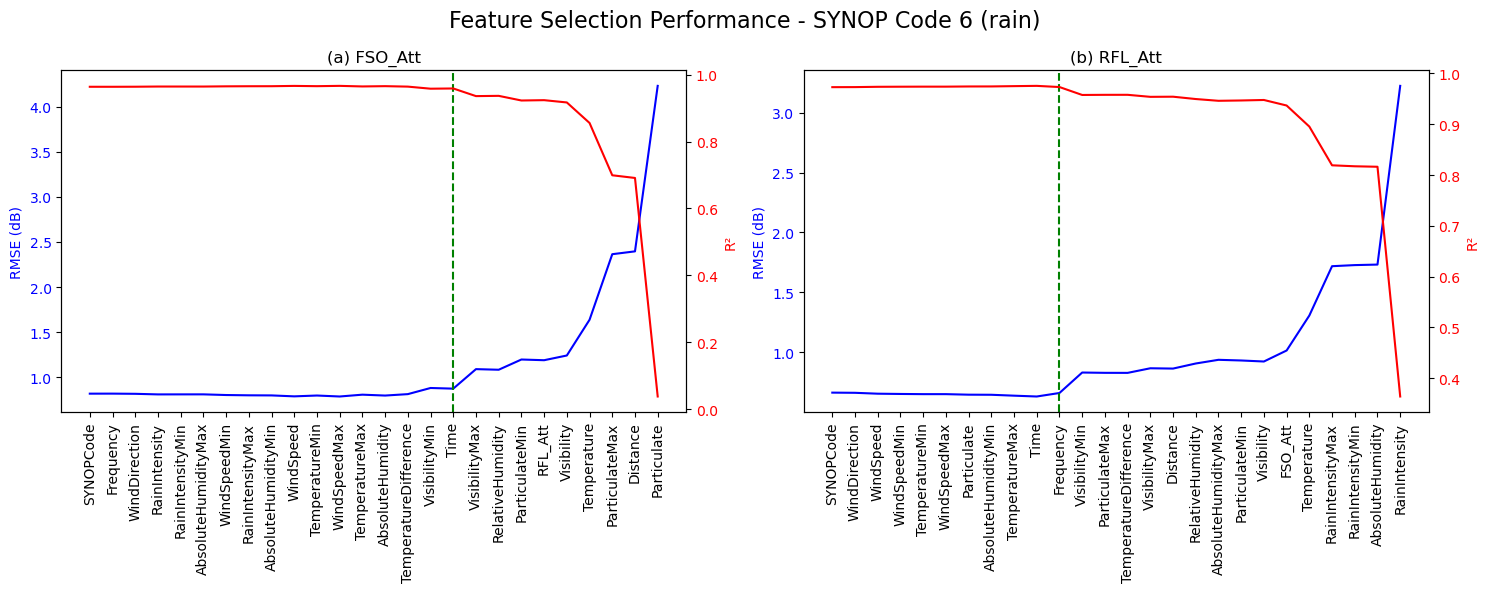

0.00026403181544240763 0.0024753049260190798
0.0003178402192643515 0.00296355757169467
-0.001018662416454371 -0.009498103267497988
-0.0003494564507064402 -0.003314241050294792
0.0009286782843381821 0.008815788508713653
-0.000828242322501615 -0.007782684869034751
8.072153147282205e-05 0.0007677987310567548
-0.0014510902545385464 -0.01388168841606037
0.0003524505535413785 0.0034422787951608165
-0.0016112297555631741 -0.01577441353108312
-0.0005969931006474195 -0.0060137286068006795
0.0010056539178072731 0.010176756910570843
-0.003431764527282813 -0.0347751179429573
-0.00035293892363558367 -0.003792171890837433
0.0041325943909078814 0.04371692482752598
-0.004568596424307583 -0.046215730019566005
-9.786954966244236e-05 -0.0010685937150134005
0.011648079032635247 0.12017566850441093
-0.001344130813211565 -0.015278998152881104
-0.0002710691301535169 -0.0031626208272611247
0.0016776671040041697 0.01948249336021962
-0.0018671787565066895 -0.021256238848698046
-0.0006009443401038619 -0.00710414

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(fso_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)


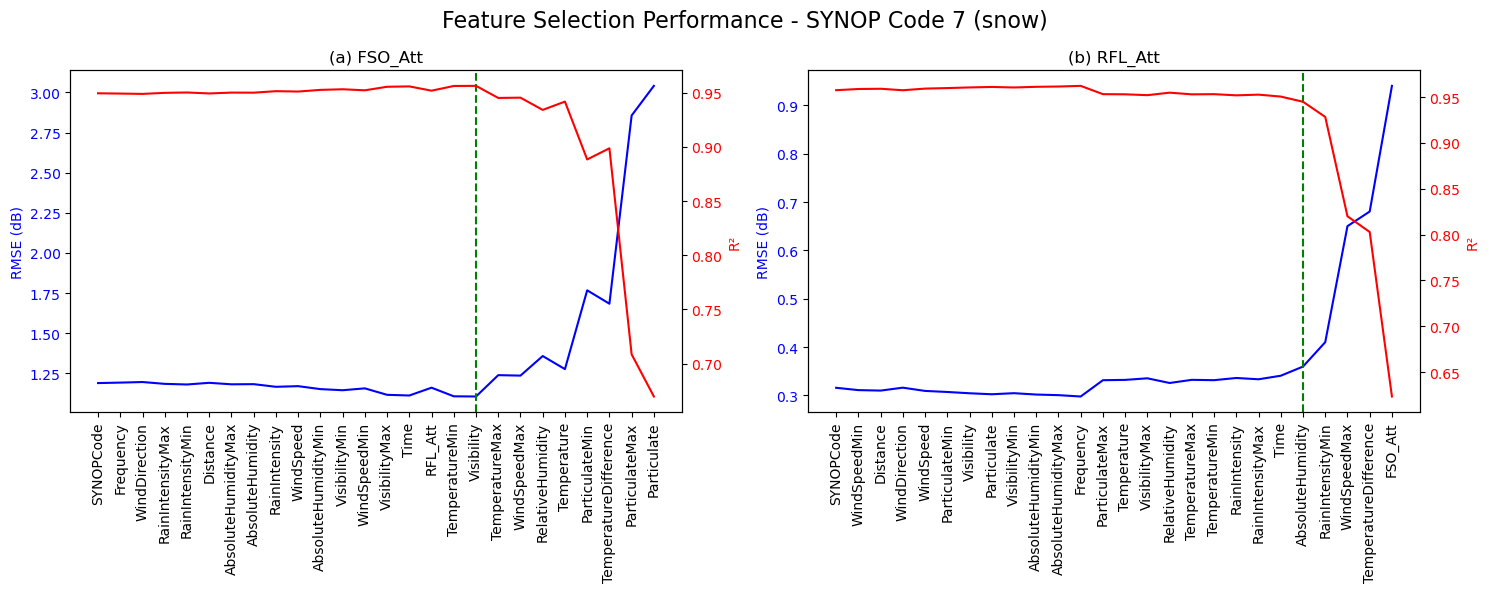

-0.0004913104771296023 -0.004777294782826227
0.0011753091638630597 0.011450722445109326
-0.0009144177346349098 -0.008786517753641422
2.598028100271153e-05 0.0002531695067577251
-0.0008940151777553504 -0.008746609279696385
-0.00020453608974639248 -0.0020315213946885927
-0.0010382916431507367 -0.01040037318831247
-0.0007217665374644789 -0.007379024388736521
-0.0003038792778400365 -0.0031486813067813147
-7.962229342335395e-05 -0.0008295248118540067
0.0038775363861139785 0.039664059326840286
-0.0008043875352577889 -0.007763382902024063
0.004331096748048609 0.04146683133741146
0.00010139961553242823 0.0009092394472552448
-0.000415290142816235 -0.003725351411944444
-0.0029178950669468003 -0.02668899426737052
0.007284891364703056 0.06733373073202753
-0.002149070137122212 -0.01805524542118474
0.006029898386611402 0.05088288221216494
0.002985343068785391 0.022986273297809248
0.03157264679056249 0.21183043014742906
-0.0009347279845452869 -0.005140859299247688
-0.003505098303833332 -0.01963816619

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(fso_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/1475388608.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)


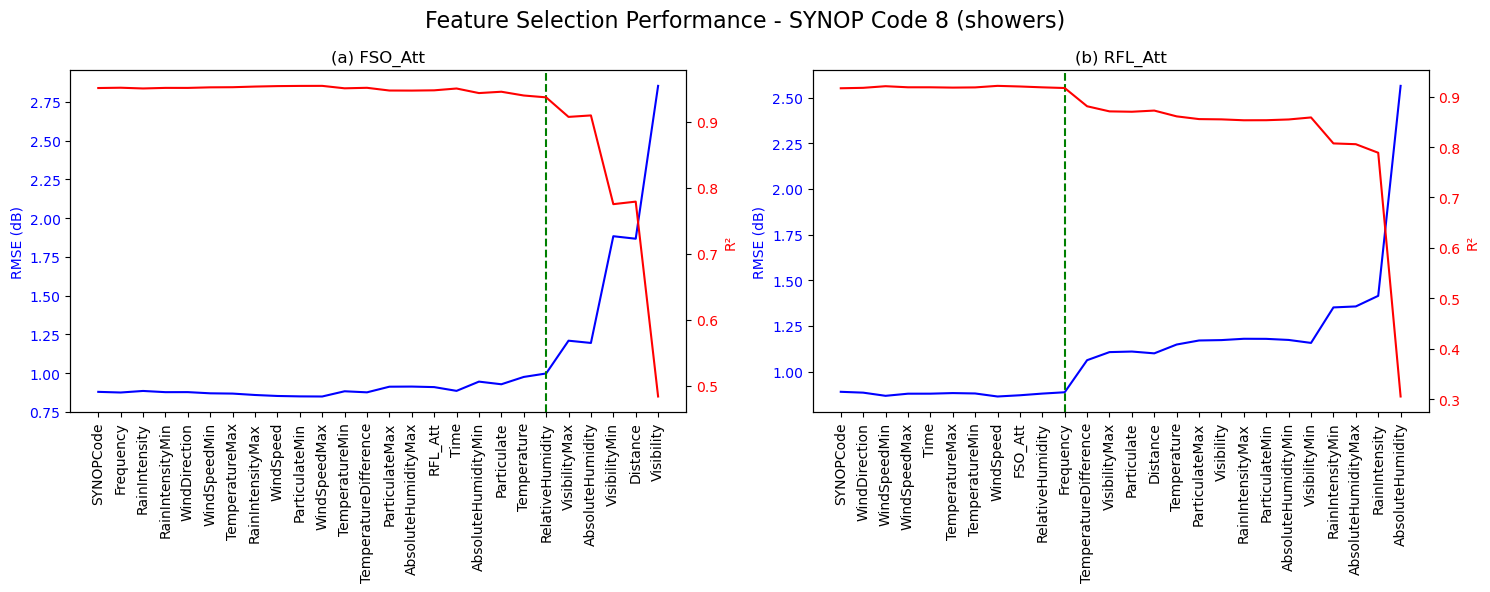

In [ ]:
# Perform feature selection and plotting for each subset of data by SYNOP code
rfl_table_final = pd.DataFrame(columns = ['SYNOPCode','Removed_Feature', 'RMSE', 'R2'])
fso_table_final =  pd.DataFrame(columns = ['SYNOPCode','Removed_Feature', 'RMSE', 'R2'])
for code, condition in synop_codes.items():
    subset_data = data[data['SYNOPCode'] == code]
    
    # Skip if the subset is too small to train
    if len(subset_data) < 100:
        print(f"Skipping SYNOP code {code} ({condition}) due to insufficient data.")
        continue
    
    # Initialize separate tables for FSO_Att and RFL_Att for each SYNOP code
    target_features = ['FSO_Att', 'RFL_Att']
    result_tables = {target: [] for target in target_features}

    for target in target_features:
        remaining_features = [col for col in subset_data.columns if col != target]
        
        while remaining_features:
            rf = RandomForestRegressor(oob_score=True, random_state=42)
            rf.fit(subset_data[remaining_features], subset_data[target])

            oob_predictions = rf.oob_prediction_
            rmse = sqrt(mean_squared_error(subset_data[target], oob_predictions))
            r2 = r2_score(subset_data[target], oob_predictions)

            importances = rf.feature_importances_
            feature_importances = pd.Series(importances, index=remaining_features).sort_values()

            least_important_feature = feature_importances.idxmin()

            result_tables[target].append({
                'Removed_Feature': least_important_feature,
                'RMSE': rmse,
                'R2': r2
            })

            remaining_features.remove(least_important_feature)

    # Convert result tables to DataFrames
    fso_table = pd.DataFrame(result_tables['FSO_Att'])
    rfl_table = pd.DataFrame(result_tables['RFL_Att'])
    fso_table['SYNOPCode'] = code
    rfl_table['SYNOPCode'] = code
    fso_threshold = find_threshold(fso_table)
    rfl_threshold = find_threshold(rfl_table)

    rfl_table_final = pd.concat([rfl_table_final, rfl_table])
    fso_table_final = pd.concat([fso_table_final, fso_table])

    # Plotting RMSE and R² for FSO_Att and RFL_Att for each SYNOP code subset
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f"Feature Selection Performance - SYNOP Code {code} ({condition})", fontsize=16)

    # Plot for FSO_Att
    axes[0].plot(fso_table['Removed_Feature'], fso_table['RMSE'], label="RMSE (dB)", color="blue")
    axes[0].set_ylabel("RMSE (dB)", color="blue")
    axes[0].tick_params(axis="y", labelcolor="blue")
    ax2 = axes[0].twinx()
    ax2.plot(fso_table['Removed_Feature'], fso_table['R2'], label="R²", color="red")
    ax2.set_ylabel("R²", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    axes[0].axvline(x=fso_threshold, color="green", linestyle="--", label="1% R² Threshold")
    axes[0].set_title("(a) FSO_Att")
    axes[0].set_xticklabels(fso_table['Removed_Feature'], rotation=90)

    # Plot for RFL_Att
    axes[1].plot(rfl_table['Removed_Feature'], rfl_table['RMSE'], label="RMSE (dB)", color="blue")
    axes[1].set_ylabel("RMSE (dB)", color="blue")
    axes[1].tick_params(axis="y", labelcolor="blue")
    ax4 = axes[1].twinx()
    ax4.plot(rfl_table['Removed_Feature'], rfl_table['R2'], label="R²", color="red")
    ax4.set_ylabel("R²", color="red")
    ax4.tick_params(axis="y", labelcolor="red")
    axes[1].axvline(x=rfl_threshold, color="green", linestyle="--", label="1% R² Threshold")
    axes[1].set_title("(b) RFL_Att")
    axes[1].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)

    plt.tight_layout()
    plt.show()


### Method 2 (Generic random forest) 

In [89]:
# Initialize separate tables for FSO_Att and RFL_Att
target_features = ['FSO_Att', 'RFL_Att']
result_tables = {target: [] for target in target_features}

for target in target_features:
    # Initialize feature set and empty results table for each target
    remaining_features = [col for col in data.columns if col != target]
    
    # Iteratively perform feature selection
    while remaining_features:
        # Train Random Forest with current features
        rf = RandomForestRegressor(oob_score=True, random_state=42)
        rf.fit(data[remaining_features], data[target])

        # Calculate RMSE and R² using OOB predictions
        oob_predictions = rf.oob_prediction_
        rmse = sqrt(mean_squared_error(data[target], oob_predictions))
        r2 = r2_score(data[target], oob_predictions)

        # Feature importances for ranking
        importances = rf.feature_importances_
        feature_importances = pd.Series(importances, index=remaining_features).sort_values()

        # Get least important feature
        least_important_feature = feature_importances.idxmin()

        # Append results to the target's result table
        result_tables[target].append({
            'Removed_Feature': least_important_feature,
            'RMSE': rmse,
            'R2': r2
        })

        # Remove least important feature from remaining features
        remaining_features.remove(least_important_feature)

# Convert result tables to DataFrames
fso_table = pd.DataFrame(result_tables['FSO_Att'])
rfl_table = pd.DataFrame(result_tables['RFL_Att'])
fso_table['SYNOPCode'] = 'generic'
rfl_table['SYNOPCode'] = 'generic'
fso_threshold = find_threshold(fso_table)
rfl_threshold = find_threshold(rfl_table)

rfl_table_final = pd.concat([rfl_table_final, rfl_table])
fso_table_final = pd.concat([fso_table_final, fso_table])


KeyboardInterrupt: 

In [113]:
fso_table['SYNOPCode'] = 'generic'
rfl_table['SYNOPCode'] = 'generic'
fso_threshold = find_threshold(fso_table)
rfl_threshold = find_threshold(rfl_table)

rfl_table_final = pd.concat([rfl_table_final, rfl_table])
fso_table_final = pd.concat([fso_table_final, fso_table])

/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/3151652737.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(fso_table['Removed_Feature'], rotation=90)
/var/folders/bq/6pxxtk6s1rq_ydzqc18mychr0000gn/T/ipykernel_37847/3151652737.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)


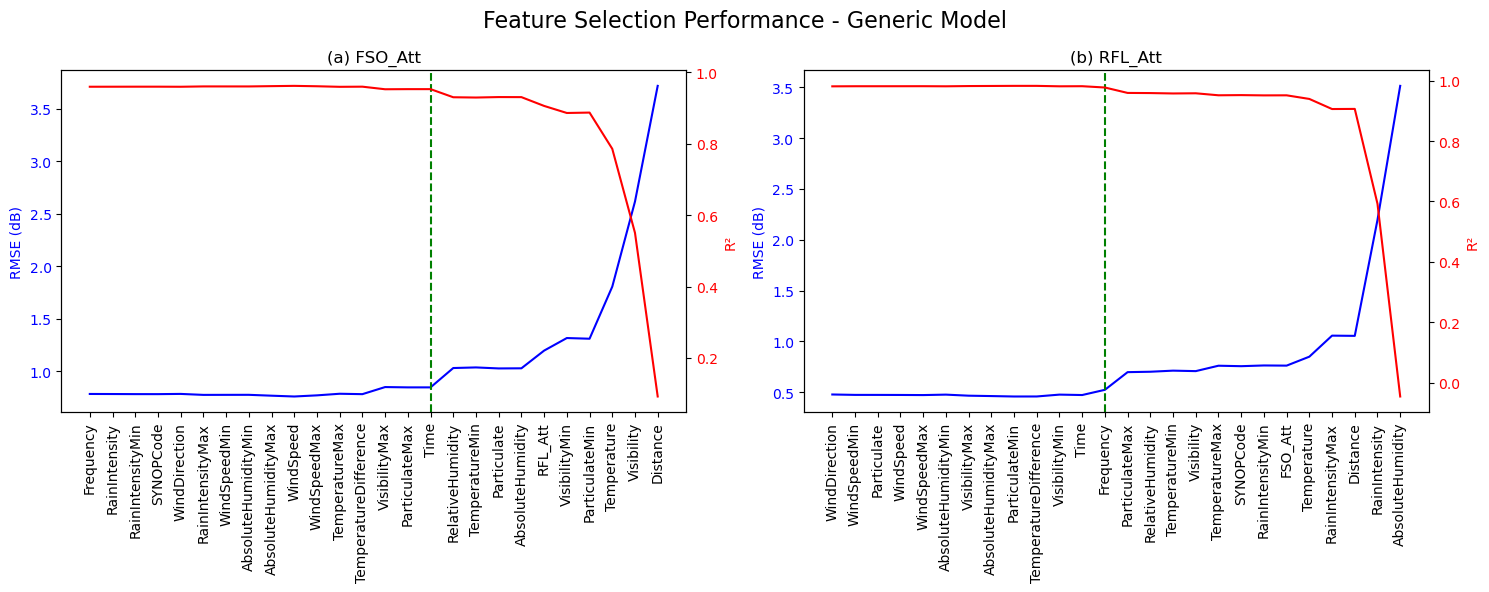

In [114]:

# Plotting similar to the example for both FSO_Att and RFL_Att
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle(f"Feature Selection Performance - Generic Model", fontsize=16)
# Plot for FSO_Att
axes[0].plot(fso_table['Removed_Feature'], fso_table['RMSE'], label="RMSE (dB)", color="blue")
axes[0].set_ylabel("RMSE (dB)", color="blue")
axes[0].tick_params(axis="y", labelcolor="blue")
ax2 = axes[0].twinx()
ax2.plot(fso_table['Removed_Feature'], fso_table['R2'], label="R²", color="red")
ax2.set_ylabel("R²", color="red")
ax2.tick_params(axis="y", labelcolor="red")
axes[0].axvline(x=fso_threshold, color="green", linestyle="--", label="1% R² Threshold")
axes[0].set_title("(a) FSO_Att")
axes[0].set_xticklabels(fso_table['Removed_Feature'], rotation=90)

# Plot for RFL_Att
axes[1].plot(rfl_table['Removed_Feature'], rfl_table['RMSE'], label="RMSE (dB)", color="blue")
axes[1].set_ylabel("RMSE (dB)", color="blue")
axes[1].tick_params(axis="y", labelcolor="blue")
ax4 = axes[1].twinx()
ax4.plot(rfl_table['Removed_Feature'], rfl_table['R2'], label="R²", color="red")
ax4.set_ylabel("R²", color="red")
ax4.tick_params(axis="y", labelcolor="red")
axes[1].axvline(x=rfl_threshold, color="green", linestyle="--", label="1% R² Threshold")
axes[1].set_title("(b) RFL_Att")
axes[1].set_xticklabels(rfl_table['Removed_Feature'], rotation=90)

plt.tight_layout()
plt.show()


In [115]:
rfl_table_final.to_csv('rfl_table_specific.csv', index = False)
fso_table_final.to_csv('fso_table_specific.csv', index = False)


In [116]:
def extract_selected_features(table, r2_threshold=0.01, rmse_threshold=0.05):
    """
    Finds the threshold for selecting the most important features.
    Stops removing features when the change in R² or RMSE meets the thresholds.
    """
    selected_features = []
    for i in range(1, len(table)):
        # Calculate changes in RMSE and R²
        rmse_diff = (table['RMSE'].iloc[i] - table['RMSE'].iloc[i - 1]) / table['RMSE'].iloc[i - 1]
        r2_diff = table['R2'].iloc[i] - table['R2'].iloc[i - 1]
        
        # Stop if threshold is met
        if r2_diff < r2_threshold and rmse_diff > rmse_threshold:
            selected_features = table['Removed_Feature'].iloc[:i].tolist()
            break
    return selected_features


In [117]:
fso_table_final.groupby('SYNOPCode')

In [118]:
# Get unique selected features for each target model after thresholding
fso_important_features = fso_table_final.groupby('SYNOPCode')[['RMSE','R2','Removed_Feature']].apply(lambda x: extract_selected_features(x))
rfl_important_features = rfl_table_final.groupby('SYNOPCode')[['RMSE','R2','Removed_Feature']].apply(lambda x: extract_selected_features(x))


In [119]:
fso_important_features

SYNOPCode
0          [SYNOPCode, RainIntensityMin, RainIntensityMax...
3          [RainIntensityMax, SYNOPCode, RainIntensity, R...
4          [SYNOPCode, Frequency, RainIntensityMax, RainI...
5          [SYNOPCode, Frequency, RainIntensityMax, WindD...
6          [SYNOPCode, Frequency, WindDirection, RainInte...
7          [SYNOPCode, Frequency, WindDirection, RainInte...
8          [SYNOPCode, Frequency, RainIntensity, RainInte...
generic    [Frequency, RainIntensity, RainIntensityMin, S...
dtype: object

In [120]:
rfl_important_features

SYNOPCode
0          [SYNOPCode, ParticulateMax, RainIntensityMax, ...
3          [Particulate, SYNOPCode, ParticulateMax, Parti...
4          [SYNOPCode, WindSpeedMin, WindSpeed, Distance,...
5          [SYNOPCode, WindDirection, WindSpeedMin, WindS...
6          [SYNOPCode, WindDirection, WindSpeed, WindSpee...
7          [SYNOPCode, WindSpeedMin, Distance, WindDirect...
8          [SYNOPCode, WindDirection, WindSpeedMin, WindS...
generic    [WindDirection, WindSpeedMin, Particulate, Win...
dtype: object

In [141]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

def train_and_evaluate_with_hyperparameter_tuning(data, fso_features, rfl_features, param_grid):
    # Split the data into train+valid and test sets, stratified by SYNOPCode
    train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['SYNOPCode'], random_state=42)

    # Initialize dictionaries to store results and best parameters
    rmse_results = {'RFL_Specific': [], 'RFL_Generic': [], 'FSO_Specific': [], 'FSO_Generic': []}
    r2_results = {'RFL_Specific': [], 'RFL_Generic': [], 'FSO_Specific': [], 'FSO_Generic': []}
    best_params_fso = {}
    best_params_rfl = {}
    synop_conditions = list(synop_codes.values())

    # Method 1: Hyperparameter tuning for specific models
    for code in synop_codes.keys():
        train_subset = train_data[train_data['SYNOPCode'] == code]

        if len(train_subset) < 100:
            continue

        # Hyperparameter tuning for FSO_Att specific model
        X_train_fso = train_subset[fso_features[code]]
        y_train_fso = train_subset['FSO_Att']
        rf_fso = RandomForestRegressor(random_state=42)
        rf_fso_random = RandomizedSearchCV(estimator=rf_fso, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)
        rf_fso_random.fit(X_train_fso, y_train_fso)
        best_params_fso[code] = rf_fso_random.best_params_

        # Hyperparameter tuning for RFL_Att specific model
        X_train_rfl = train_subset[rfl_features[code]]
        y_train_rfl = train_subset['RFL_Att']
        rf_rfl = RandomForestRegressor(random_state=42)
        rf_rfl_random = RandomizedSearchCV(estimator=rf_rfl, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)
        rf_rfl_random.fit(X_train_rfl, y_train_rfl)
        best_params_rfl[code] = rf_rfl_random.best_params_

    # Method 2: Hyperparameter tuning for generic models
    train_data['SYNOPCode'] = train_data['SYNOPCode'].astype('category')
    test_data['SYNOPCode'] = test_data['SYNOPCode'].astype('category')

    # Hyperparameter tuning for FSO_Generic model
    rf_fso_generic = RandomForestRegressor(random_state=42)
    rf_fso_generic_random = RandomizedSearchCV(estimator=rf_fso_generic, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)
    rf_fso_generic_random.fit(train_data[fso_features['generic']], train_data['FSO_Att'])
    best_params_fso['generic'] = rf_fso_generic_random.best_params_

    # Hyperparameter tuning for RFL_Generic model
    rf_rfl_generic = RandomForestRegressor(random_state=42)
    rf_rfl_generic_random = RandomizedSearchCV(estimator=rf_rfl_generic, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)
    rf_rfl_generic_random.fit(train_data[rfl_features['generic']], train_data['RFL_Att'])
    best_params_rfl['generic'] = rf_rfl_generic_random.best_params_

    # Train final specific models and evaluate on the test set
    for code in synop_codes.keys():
        train_subset = train_data[train_data['SYNOPCode'] == code]
        test_subset = test_data[test_data['SYNOPCode'] == code]

        if len(train_subset) < 100 or len(test_subset) < 10:
            continue

        # FSO_Specific model
        fso_model_final = RandomForestRegressor(**best_params_fso[code], random_state=42)
        fso_model_final.fit(train_subset[fso_features[code]], train_subset['FSO_Att'])
        fso_preds_final = fso_model_final.predict(test_subset[fso_features[code]])
        rmse_results['FSO_Specific'].append(np.sqrt(mean_squared_error(test_subset['FSO_Att'], fso_preds_final)))
        r2_results['FSO_Specific'].append(r2_score(test_subset['FSO_Att'], fso_preds_final))

        # RFL_Specific model
        rfl_model_final = RandomForestRegressor(**best_params_rfl[code], random_state=42)
        rfl_model_final.fit(train_subset[rfl_features[code]], train_subset['RFL_Att'])
        rfl_preds_final = rfl_model_final.predict(test_subset[rfl_features[code]])
        rmse_results['RFL_Specific'].append(np.sqrt(mean_squared_error(test_subset['RFL_Att'], rfl_preds_final)))
        r2_results['RFL_Specific'].append(r2_score(test_subset['RFL_Att'], rfl_preds_final))

    # Train final generic models and evaluate on each SYNOPCode subset in the test set
    fso_generic_model = RandomForestRegressor(**best_params_fso['generic'], random_state=42)
    fso_generic_model.fit(train_data[fso_features['generic']], train_data['FSO_Att'])
    rfl_generic_model = RandomForestRegressor(**best_params_rfl['generic'], random_state=42)
    rfl_generic_model.fit(train_data[rfl_features['generic']], train_data['RFL_Att'])

    for code in synop_codes.keys():
        test_subset = test_data[test_data['SYNOPCode'] == code]
        if len(test_subset) < 10:
            continue

        # FSO_Generic model evaluation
        fso_generic_preds = fso_generic_model.predict(test_subset[fso_features['generic']])
        rmse_results['FSO_Generic'].append(np.sqrt(mean_squared_error(test_subset['FSO_Att'], fso_generic_preds)))
        r2_results['FSO_Generic'].append(r2_score(test_subset['FSO_Att'], fso_generic_preds))

        # RFL_Generic model evaluation
        rfl_generic_preds = rfl_generic_model.predict(test_subset[rfl_features['generic']])
        rmse_results['RFL_Generic'].append(np.sqrt(mean_squared_error(test_subset['RFL_Att'], rfl_generic_preds)))
        r2_results['RFL_Generic'].append(r2_score(test_subset['RFL_Att'], rfl_generic_preds))

    return rmse_results, r2_results, synop_conditions, best_params_fso, best_params_rfl

# Execute the function with the defined parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rmse_results, r2_results, synop_conditions, best_params_fso, best_params_rfl = train_and_evaluate_with_hyperparameter_tuning(
    data, fso_important_features, rfl_important_features, param_grid
)

# Display results and best parameters
print("RMSE Results:", rmse_results)
print("R² Results:", r2_results)
print("Best Parameters for FSO_Att:", best_params_fso)
print("Best Parameters for RFL_Att:", best_params_rfl)


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


NameError: name 'train' is not defined

KeyError: 'RFL_Specific'

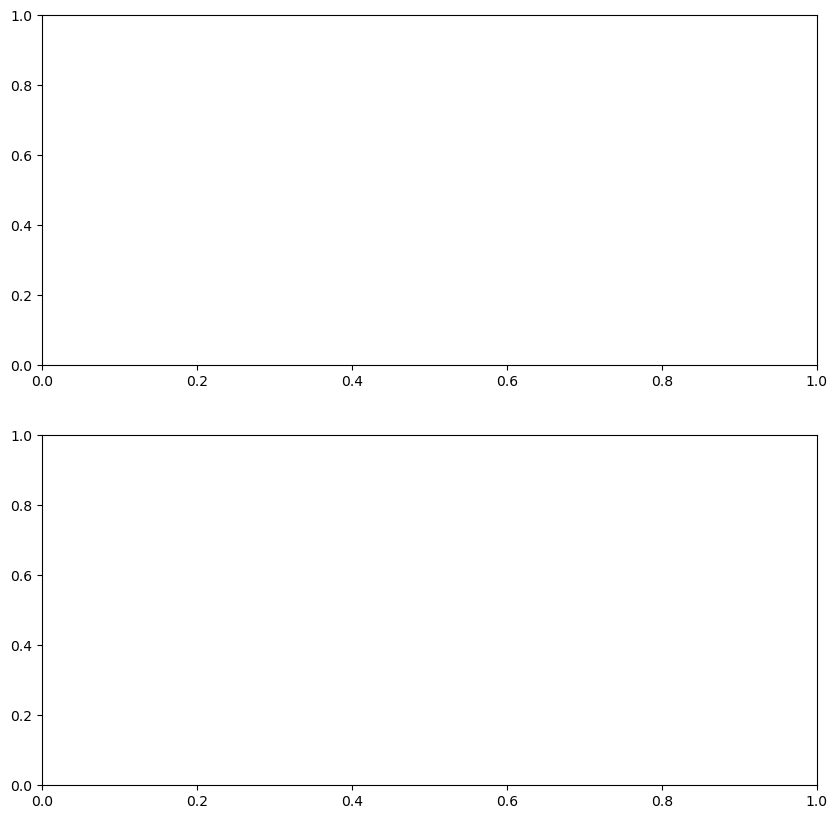

In [140]:
# Plot RMSE and R² results
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# RMSE plot
axes[0].plot(synop_conditions, rmse_results['RFL_Specific'], 'r-', marker='x', label="RFL from Specific Model")
axes[0].plot(synop_conditions, rmse_results['RFL_Generic'], 'r--', marker='o', label="RFL from Generic Model")
axes[0].plot(synop_conditions, rmse_results['FSO_Specific'], 'g-', marker='x', label="FSO from Specific Model")
axes[0].plot(synop_conditions, rmse_results['FSO_Generic'], 'g--', marker='o', label="FSO from Generic Model")
axes[0].set_xlabel("Weather Condition")
axes[0].set_ylabel("RMSE (dB)")
axes[0].set_title("(a) RMSE")
axes[0].legend(loc="upper right")
axes[0].grid(True)

# R² plot
axes[1].plot(synop_conditions, r2_results['RFL_Specific'], 'r-', marker='x', label="RFL from Specific Model")
axes[1].plot(synop_conditions, r2_results['RFL_Generic'], 'r--', marker='o', label="RFL from Generic Model")
axes[1].plot(synop_conditions, r2_results['FSO_Specific'], 'g-', marker='x', label="FSO from Specific Model")
axes[1].plot(synop_conditions, r2_results['FSO_Generic'], 'g--', marker='o', label="FSO from Generic Model")
axes[1].set_xlabel("Weather Condition")
axes[1].set_ylabel("$R^2$")
axes[1].set_title("(b) $R^2$")
axes[1].legend(loc="upper right")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [134]:
rmse_results

{'RFL_Specific': [0.9273907183771751,
  0.5947233662899346,
  0.702227509963714,
  1.013475740822167,
  2.016406414220318,
  0.6506666824648594,
  1.4626980096503963],
 'RFL_Generic': [1.2847526773962055,
  1.011238868771474,
  0.7371333533009062,
  1.1179365245408335,
  1.9438270174079424,
  0.6571500657980047,
  1.5332703141760184],
 'FSO_Specific': [3.228796502402279,
  3.1792199407677675,
  1.489361920164681,
  1.3880444270344756,
  1.954449963362181,
  2.398655609018556,
  1.312748767080017],
 'FSO_Generic': [2.268677614083684,
  3.5203005576028614,
  1.5638736472732877,
  1.8367008693555449,
  2.1848404244672834,
  1.873796343288288,
  2.1427544760560306]}

In [138]:
# Define SYNOP codes and corresponding weather conditions
synop_conditions = list(synop_codes.values())

# Initialize dictionaries to store improvement data
rmse_improvement = {'SYNOPCode': [], 'RFL_RMSE_Improvement': [], 'FSO_RMSE_Improvement': []}
r2_improvement = {'SYNOPCode': [], 'RFL_R2_Improvement': [], 'FSO_R2_Improvement': []}

# Calculate the improvement for each SYNOP code
for i, condition in enumerate(synop_conditions):
    # RMSE improvement for RFL and FSO
    rfl_rmse_improvement = ((rmse_results['RFL_Generic'][i] - rmse_results['RFL_Specific'][i]) / rmse_results['RFL_Generic'][i]) * 100
    fso_rmse_improvement = ((rmse_results['FSO_Generic'][i] - rmse_results['FSO_Specific'][i]) / rmse_results['FSO_Generic'][i]) * 100
    
    # R² improvement for RFL and FSO
    rfl_r2_improvement = ((r2_results['RFL_Specific'][i] - r2_results['RFL_Generic'][i]) / r2_results['RFL_Generic'][i]) * 100
    fso_r2_improvement = ((r2_results['FSO_Specific'][i] - r2_results['FSO_Generic'][i]) / r2_results['FSO_Generic'][i]) * 100

    # Append results to improvement dictionaries
    rmse_improvement['SYNOPCode'].append(condition)
    rmse_improvement['RFL_RMSE_Improvement'].append(f"{rfl_rmse_improvement:.2f}%")
    rmse_improvement['FSO_RMSE_Improvement'].append(f"{fso_rmse_improvement:.2f}%")

    r2_improvement['SYNOPCode'].append(condition)
    r2_improvement['RFL_R2_Improvement'].append(f"{rfl_r2_improvement:.2f}%")
    r2_improvement['FSO_R2_Improvement'].append(f"{fso_r2_improvement:.2f}%")

# Convert improvements to DataFrames
rmse_improvement_df = pd.DataFrame(rmse_improvement)
r2_improvement_df = pd.DataFrame(r2_improvement)

# Merge RMSE and R² improvements into a single table
improvement_table = rmse_improvement_df.merge(r2_improvement_df, on='SYNOPCode')

# Display the table for review
improvement_table

,SYNOPCode,RFL_RMSE_Improvement,FSO_RMSE_Improvement,RFL_R2_Improvement,FSO_R2_Improvement
0,clear,26.35%,-36.34%,15.20%,-72.29%
1,dust storm,47.72%,-4.05%,9.33%,-1.01%
2,fog,-8.56%,5.75%,-6.00%,2.36%
3,drizzle,12.44%,20.93%,4.03%,9.35%
4,rain,-7.11%,12.16%,-3.97%,6.99%
5,snow,2.22%,-29.00%,1.63%,-9.29%
6,showers,17.05%,33.48%,21.23%,29.83%


## Hyperparameter Tuning with Selected Features

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Run tuning for FSO_Att model with selected features
best_params_fso = {}
for code, features in fso_important_features.items():
    X = data[data['SYNOPCode'] == code][features]
    y = data[data['SYNOPCode'] == code]['FSO_Att']
    
    rf = RandomForestRegressor(random_state=42)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)
    rf_random.fit(X, y)
    
    best_params_fso[code] = rf_random.best_params_

print("Best Parameters for FSO_Att:", best_params_fso)
